In [230]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

import torch
import torch.nn as nn
from torch.autograd import Variable
import os
import optuna

seed = 211
np.random.seed(seed)
torch.manual_seed(seed)

<ipython-input-230-b679438caf39>:9: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [231]:
def load_nasdaq(use_fed_data = True):
    filepath = 'input/NASDAQ_DAYLY.csv'
    nasdaq = pd.read_csv(filepath)
    nasdaq['Date'] = pd.to_datetime(nasdaq['Date'], format = '%Y-%m-%d')
    nasdaq = nasdaq.set_index('Date')
    nasdaq = nasdaq[['Close']]
    filepath = 'input/WALCL.csv'
    assets = pd.read_csv(filepath)
    assets['DATE'] = pd.to_datetime(assets['DATE'], format = '%Y-%m-%d')
    assets = assets.rename(columns={'DATE':'Date',"WALCL":'Millions_of_Dollars'})
    assets.set_index('Date',inplace=True)
    nasdaq['Assets'] = assets['Millions_of_Dollars']
    nasdaq = nasdaq.dropna()
    scaled = nasdaq.copy()
    scaler1 = MinMaxScaler(feature_range=(min(nasdaq['Close'])/max(nasdaq['Close']), 1))
    scaled ['Close'] = scaler1.fit_transform(scaled['Close'].values.reshape(-1,1))
    scaler2 = MinMaxScaler(feature_range=(min(nasdaq['Assets'])/max(nasdaq['Assets']), 1))
    scaled ['Assets'] = scaler2.fit_transform(scaled['Assets'].values.reshape(-1,1))
    if not use_fed_data:
        del nasdaq['Assets']
        del scaled['Assets']
    return nasdaq, scaled, scaler1, scaler2    
        
nasdaq, scaled, scaler1, scaler2  = load_nasdaq()  

In [232]:
nasdaq

,Close,Assets
Date,,
2002-12-18,1013.669983,719542.0
2003-01-08,1042.520020,723762.0
2003-01-15,1073.599976,720074.0
2003-01-22,1006.510010,735953.0
2003-01-29,1016.559998,712809.0
...,...,...
2021-05-12,13001.629883,7830663.0
2021-05-19,13237.910156,7922883.0
2021-05-26,13702.740234,7903541.0


In [233]:
scaled

,Close,Assets
Date,,
2002-12-18,0.072742,0.090482
2003-01-08,0.074812,0.091013
2003-01-15,0.077043,0.090549
2003-01-22,0.072228,0.092546
2003-01-29,0.072949,0.089635
...,...,...
2021-05-12,0.933010,0.984701
2021-05-19,0.949965,0.996297
2021-05-26,0.983322,0.993865


In [234]:
# function to create train, test data given stock data and sequence lengt
def load_data(stock, look_back, batch_size, prev_perm = None ,use_perm = True):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back + 1): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    np.random.seed(seed)
    if prev_perm is not None:
        rand_perm = prev_perm
    else:
        rand_perm = np.random.permutation(data.shape[0])
    if use_perm: 
        data = data[rand_perm,:,:]
    
    x_train_full = data[:train_set_size,:-1,:]
    y_train_full = data[:train_set_size,-1,:]
    y_train_full = y_train_full[:,0].reshape(-1,1)
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    y_test = y_test[:,0].reshape(-1,1)
    
    
    x_train_full = torch.from_numpy(x_train_full).type(torch.Tensor).to(device)
    x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
    y_train_full = torch.from_numpy(y_train_full).type(torch.Tensor).to(device)
    y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)
    
    x_train = []
    y_train = []
    
    for b in range(len(x_train_full)//batch_size):
        m = min((b+1)*batch_size,len(x_train_full)+1)
        x_train.append(x_train_full[b*batch_size:m])
        y_train.append(y_train_full[b*batch_size:m])
    
    
      
    
    return [x_train, y_train, x_test, y_test, x_train_full, y_train_full]

In [235]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        torch.manual_seed(seed)
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out
    
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        torch.manual_seed(seed)
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [236]:
def objective(trial):
    look_back = trial.suggest_int("Look Back",10,100)
    batch_size = trial.suggest_int("Batch Size",16,256,log=True)
    hidden_dim = trial.suggest_int("Hidden Dim",16,128,log=True)
    num_layers = trial.suggest_int("N layers",1,5)
    lr = trial.suggest_float("Learning Rate",1e-4,0.1,log=True)
    num_iters = trial.suggest_int("Num Iters",1000,4000)
    factor = trial.suggest_float('Factor',0.1,1,log=True)
    patience = trial.suggest_int("Patience",1,30)
    
    [x_train, y_train, x_test, y_test, _, _]= load_data(scaled, look_back, batch_size, use_perm=True)
    output_dim = 1
    if model_name == "GRU":
        model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
    elif model_name == "LSTM":
        model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
        
    loss_fn = torch.nn.MSELoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    num_epochs = num_iters//len(x_train)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience=patience)
    for epoch in range(num_epochs):
        for batch_idx in range(len(x_train)):

            # Forward pass
            y_train_pred = model(x_train[batch_idx])

            loss = loss_fn(y_train_pred, y_train[batch_idx])

            # Zero out gradient, else they will accumulate between epochs
            optimizer.zero_grad()

            # Backward pass
            loss.backward()

            # Update parameters
            optimizer.step()
        scheduler.step(loss)
        trial.report(loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return loss

In [237]:
# now we can run the experiment
def conduct_study (study_name, model_name, n_trials = 200, timeout=120*60):
    sampler = optuna.samplers.TPESampler()
    study = optuna.create_study(study_name=study_name, direction="minimize", sampler=sampler)
    study.optimize(objective, n_trials, timeout=timeout)

    pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
    complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))
    return study

In [238]:
def train(best_trial, model_name):
    look_back = best_trial.params['Look Back']
    batch_size = best_trial.params['Batch Size']
    hidden_dim = best_trial.params['Hidden Dim']
    num_layers = best_trial.params['N layers']
    lr = best_trial.params['Learning Rate']
    num_iters = best_trial.params["Num Iters"]
    factor = best_trial.params['Factor']
    patience = best_trial.params['Patience']
    
    [x_train, y_train, x_test, y_test, x_train_full, y_train_full] = load_data(scaled, look_back, batch_size, use_perm=True)
    
    output_dim = 1
    if model_name == "GRU":
        model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
    elif model_name == "LSTM":
        model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
        
    loss_fn = torch.nn.MSELoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    num_epochs = num_iters//len(x_train)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience = patience)
    hist = np.zeros(num_epochs)
    for epoch in range(num_epochs):
        for batch_idx in range(len(x_train)):
            # Initialise hidden state

            # Forward pass
            y_train_pred = model(x_train[batch_idx])

            loss = loss_fn(y_train_pred, y_train[batch_idx])

            # Zero out gradient, else they will accumulate between epochs
            optimizer.zero_grad()

            # Backward pass
            loss.backward()

            # Update parameters
            optimizer.step()
        scheduler.step(loss)

        if epoch % 20 == 0:
            print("Epoch ", epoch, "MSE: ", loss.item())
        hist[epoch] = loss.item()
        if epoch == num_epochs-1:
            print("Last Epoch ", epoch, "MSE: ", loss.item())
    
    # plot loss
    plt.semilogy(hist, label="Training loss")
    plt.legend()
    plt.show()
    
    # make predictions
    y_test_pred = model(x_test)
    y_train_pred = model(x_train_full)
    # invert predictions

    y_train_pred = scaler1.inverse_transform(y_train_pred.cpu().detach().numpy())
    y_train = scaler1.inverse_transform(y_train_full.detach().cpu().numpy())
    y_test_pred = scaler1.inverse_transform(y_test_pred.cpu().detach().numpy())
    y_test = scaler1.inverse_transform(y_test.cpu().detach().numpy())
    return y_train_pred, y_train, y_test_pred, y_test, model
    #return [x_train, y_train, x_test, y_test, x_train_full, y_train_full], model

In [239]:
def plot_results(model, batch_size, last = 20):
    [_, _, x_test, y_test, _, _] = load_data(scaled, look_back, batch_size, use_perm = False)
    y_test_pred = model(x_test)
    y_test_pred = scaler1.inverse_transform(y_test_pred.cpu().detach().numpy())
    y_test = scaler1.inverse_transform(y_test.cpu().detach().numpy())
    figure, axes = plt.subplots(figsize=(15, 6))
    axes.xaxis_date()
    axes.plot(nasdaq[len(nasdaq)-len(y_test):].index, y_test, color = 'red', label = 'Real NASDAQ Price')
    axes.plot(nasdaq[len(nasdaq)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted NASDAQ Price')
    #axes.xticks(np.arange(0,394,50))
    plt.title('NASDAQ-100 Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('NASDAQ-100 Stock Price')
    plt.legend()
    figure, axes = plt.subplots(figsize=(15, 6))
    axes.xaxis_date()
    axes.plot(nasdaq[-last:].index, y_test[-last:], color = 'red', label = 'Real NASDAQ Price')
    axes.plot(nasdaq[-last:].index, y_test_pred[-last:], color = 'blue', label = 'Predicted NASDAQ Price')
    plt.title('NASDAQ-100 Stock Price Prediction - Last Weeks')
    plt.xlabel('Time')
    plt.ylabel('NASDAQ-100 Stock Price')
    plt.legend()

In [240]:
def predict_results(model, n=5):
    data_raw = scaled.values
    predictions = []
    n = 5
    data = np.array(data_raw[len(data_raw) - look_back:])
    x_test = data.reshape(1,data.shape[0],data.shape[1])
    x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
    for _ in range(n):
        y_test_pred = model(x_test)
        if input_dim == 2:
            tmp = torch.tensor([[[y_test_pred[0,0].item(),2*x_test[0,-1,1].item()-x_test[0,-2,1].item()]]]).to(device)
        elif input_dim ==1: 
            tmp = torch.tensor([[[y_test_pred[0,0].item()]]]).to(device)
        x_test = torch.cat((x_test,tmp),1)[:,1:,:]
        y_test_pred = scaler1.inverse_transform(y_test_pred.cpu().detach().numpy())
        predictions.append(y_test_pred.item())
        
    figure, axes = plt.subplots(figsize=(15, 6))
    print(predictions)
    axes.plot(predictions)

# Prediction with GRU

In [241]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_dim = 2

In [242]:
study_gru = conduct_study ('GRU', 'GRU')

[I 2021-06-25 16:26:54,703] A new study created in memory with name: GRU
[I 2021-06-25 16:27:17,895] Trial 0 finished with value: 0.00014986966561991721 and parameters: {'Look Back': 27, 'Batch Size': 22, 'Hidden Dim': 31, 'N layers': 5, 'Learning Rate': 0.020044833111940937, 'Num Iters': 3226, 'Factor': 0.27912517803390374, 'Patience': 11}. Best is trial 0 with value: 0.00014986966561991721.
[I 2021-06-25 16:27:37,292] Trial 1 finished with value: 6.843251321697608e-05 and parameters: {'Look Back': 61, 'Batch Size': 52, 'Hidden Dim': 21, 'N layers': 5, 'Learning Rate': 0.001211679322729983, 'Num Iters': 2003, 'Factor': 0.5674444974762092, 'Patience': 7}. Best is trial 1 with value: 6.843251321697608e-05.
[I 2021-06-25 16:27:55,131] Trial 2 finished with value: 5.678692468791269e-05 and parameters: {'Look Back': 67, 'Batch Size': 68, 'Hidden Dim': 60, 'N layers': 2, 'Learning Rate': 0.0031269090834828432, 'Num Iters': 3579, 'Factor': 0.3381889901811663, 'Patience': 7}. Best is trial 2 

[I 2021-06-25 16:29:37,608] Trial 91 pruned. 
[I 2021-06-25 16:29:37,902] Trial 92 pruned. 
[I 2021-06-25 16:29:38,248] Trial 93 pruned. 
[I 2021-06-25 16:29:38,490] Trial 94 pruned. 
[I 2021-06-25 16:29:38,752] Trial 95 pruned. 
[I 2021-06-25 16:29:39,058] Trial 96 pruned. 
[I 2021-06-25 16:29:39,154] Trial 97 pruned. 
[I 2021-06-25 16:29:39,443] Trial 98 pruned. 
[I 2021-06-25 16:29:39,568] Trial 99 pruned. 
[I 2021-06-25 16:29:39,692] Trial 100 pruned. 
[I 2021-06-25 16:29:39,957] Trial 101 pruned. 
[I 2021-06-25 16:29:40,055] Trial 102 pruned. 
[I 2021-06-25 16:29:40,622] Trial 103 pruned. 
[I 2021-06-25 16:29:40,756] Trial 104 pruned. 
[I 2021-06-25 16:29:40,843] Trial 105 pruned. 
[I 2021-06-25 16:29:51,007] Trial 106 finished with value: 2.3410613721353002e-05 and parameters: {'Look Back': 58, 'Batch Size': 18, 'Hidden Dim': 60, 'N layers': 1, 'Learning Rate': 0.010931839294830388, 'Num Iters': 3252, 'Factor': 0.3884291865212864, 'Patience': 6}. Best is trial 106 with value: 2.3

[I 2021-06-25 16:33:31,703] Trial 163 pruned. 
[I 2021-06-25 16:33:31,918] Trial 164 pruned. 
[I 2021-06-25 16:33:32,159] Trial 165 pruned. 
[I 2021-06-25 16:33:32,288] Trial 166 pruned. 
[I 2021-06-25 16:33:32,412] Trial 167 pruned. 
[I 2021-06-25 16:33:32,575] Trial 168 pruned. 
[I 2021-06-25 16:33:32,763] Trial 169 pruned. 
[I 2021-06-25 16:33:32,971] Trial 170 pruned. 
[I 2021-06-25 16:33:33,954] Trial 171 pruned. 
[I 2021-06-25 16:33:34,579] Trial 172 pruned. 
[I 2021-06-25 16:33:35,176] Trial 173 pruned. 
[I 2021-06-25 16:33:36,058] Trial 174 pruned. 
[I 2021-06-25 16:33:36,832] Trial 175 pruned. 
[I 2021-06-25 16:33:42,071] Trial 176 pruned. 
[I 2021-06-25 16:33:42,232] Trial 177 pruned. 
[I 2021-06-25 16:33:55,972] Trial 178 finished with value: 4.269629789632745e-05 and parameters: {'Look Back': 57, 'Batch Size': 16, 'Hidden Dim': 41, 'N layers': 2, 'Learning Rate': 0.015087775735153264, 'Num Iters': 3065, 'Factor': 0.12156544900329128, 'Patience': 28}. Best is trial 109 with 

Study statistics: 
  Number of finished trials:  200
  Number of pruned trials:  175
  Number of complete trials:  25


In [243]:
optuna.visualization.plot_param_importances(study_gru)

In [244]:
print("Best trial:")
trial_gru = study_gru.best_trial

print("Loss: ", trial_gru.value)
print(trial_gru.params)

Best trial:
Loss:  1.555764174554497e-05
{'Look Back': 58, 'Batch Size': 19, 'Hidden Dim': 37, 'N layers': 2, 'Learning Rate': 0.010162401079714932, 'Num Iters': 2900, 'Factor': 0.29974889341532746, 'Patience': 26}


Epoch  0 MSE:  0.0028510233387351036
Epoch  20 MSE:  0.00010944268433377147
Epoch  40 MSE:  2.525207855796907e-05
Epoch  60 MSE:  0.00013110629515722394
Last Epoch  77 MSE:  1.555764174554497e-05


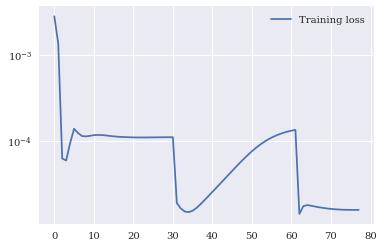

In [245]:
y_train_pred, y_train, y_test_pred, y_test, gru = train(trial_gru, "GRU")

In [246]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('GRU Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('GRU Test Score: %.2f RMSE' % (testScore))

GRU Train Score: 136.86 RMSE
GRU Test Score: 126.43 RMSE


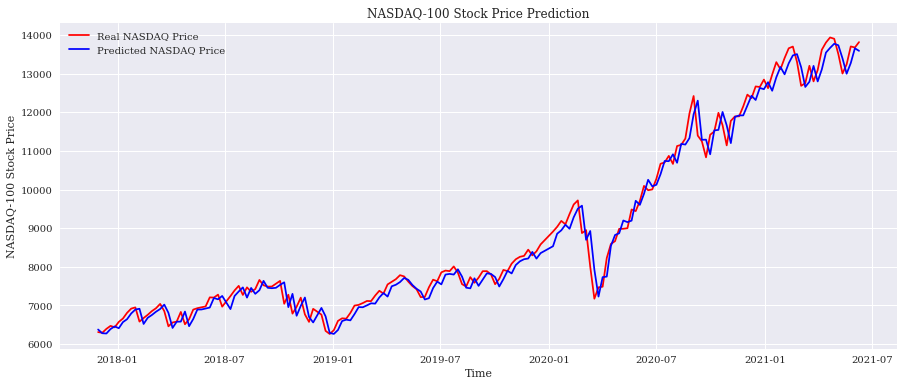

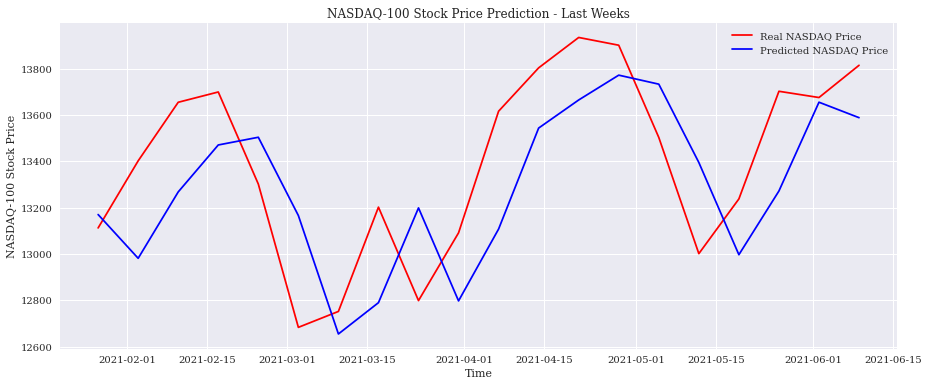

In [247]:
plot_results(gru, batch_size = trial_gru.params['Batch Size'])

[13720.478515625, 13630.779296875, 13566.6435546875, 13524.2236328125, 13497.0341796875]


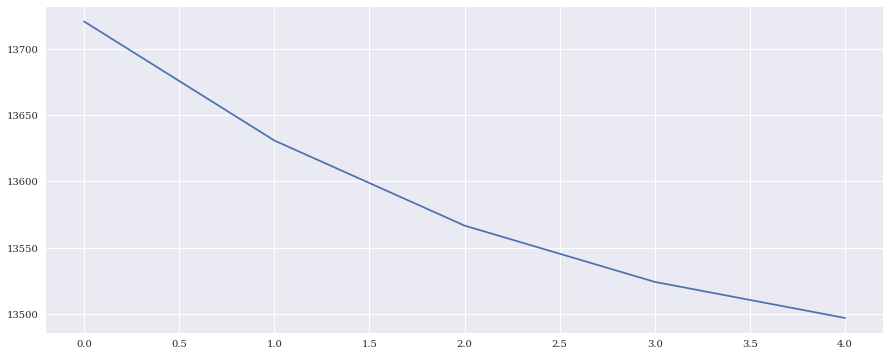

In [248]:
predict_results(gru)

# Prediction with LSTM

In [249]:
study_lstm = conduct_study ('LSTM', 'LSTM')

[I 2021-06-25 16:34:24,829] A new study created in memory with name: LSTM
[I 2021-06-25 16:34:34,325] Trial 0 finished with value: 0.00018935350817628205 and parameters: {'Look Back': 24, 'Batch Size': 80, 'Hidden Dim': 17, 'N layers': 3, 'Learning Rate': 0.0007469676605038645, 'Num Iters': 2076, 'Factor': 0.3156689518208838, 'Patience': 8}. Best is trial 0 with value: 0.00018935350817628205.
[I 2021-06-25 16:34:47,770] Trial 1 finished with value: 0.00010920649219769984 and parameters: {'Look Back': 45, 'Batch Size': 96, 'Hidden Dim': 50, 'N layers': 4, 'Learning Rate': 0.0006395786448202702, 'Num Iters': 1703, 'Factor': 0.632465278126893, 'Patience': 18}. Best is trial 1 with value: 0.00010920649219769984.
[I 2021-06-25 16:35:11,643] Trial 2 finished with value: 6.383012078003958e-05 and parameters: {'Look Back': 28, 'Batch Size': 230, 'Hidden Dim': 83, 'N layers': 4, 'Learning Rate': 0.0016267805939379825, 'Num Iters': 2300, 'Factor': 0.47739480667779854, 'Patience': 12}. Best is tr

[I 2021-06-25 16:38:45,967] Trial 58 pruned. 
[I 2021-06-25 16:38:46,025] Trial 59 pruned. 
[I 2021-06-25 16:38:46,208] Trial 60 pruned. 
[I 2021-06-25 16:38:46,570] Trial 61 pruned. 
[I 2021-06-25 16:38:55,699] Trial 62 finished with value: 6.538938032463193e-05 and parameters: {'Look Back': 26, 'Batch Size': 21, 'Hidden Dim': 117, 'N layers': 1, 'Learning Rate': 0.009234307519165772, 'Num Iters': 3825, 'Factor': 0.5090590969047669, 'Patience': 19}. Best is trial 32 with value: 3.629981802077964e-05.
[I 2021-06-25 16:39:04,612] Trial 63 finished with value: 5.6546341511420906e-05 and parameters: {'Look Back': 22, 'Batch Size': 22, 'Hidden Dim': 93, 'N layers': 1, 'Learning Rate': 0.009791990749868296, 'Num Iters': 3832, 'Factor': 0.6573709560102614, 'Patience': 19}. Best is trial 32 with value: 3.629981802077964e-05.
[I 2021-06-25 16:39:04,724] Trial 64 pruned. 
[I 2021-06-25 16:39:04,767] Trial 65 pruned. 
[I 2021-06-25 16:39:04,942] Trial 66 pruned. 
[I 2021-06-25 16:39:05,018] Tria

[I 2021-06-25 16:40:19,844] Trial 168 pruned. 
[I 2021-06-25 16:40:19,911] Trial 169 pruned. 
[I 2021-06-25 16:40:20,086] Trial 170 pruned. 
[I 2021-06-25 16:40:20,254] Trial 171 pruned. 
[I 2021-06-25 16:40:20,661] Trial 172 pruned. 
[I 2021-06-25 16:40:20,799] Trial 173 pruned. 
[I 2021-06-25 16:40:20,928] Trial 174 pruned. 
[I 2021-06-25 16:40:21,155] Trial 175 pruned. 
[I 2021-06-25 16:40:21,306] Trial 176 pruned. 
[I 2021-06-25 16:40:21,937] Trial 177 pruned. 
[I 2021-06-25 16:40:22,496] Trial 178 pruned. 
[I 2021-06-25 16:40:23,343] Trial 179 pruned. 
[I 2021-06-25 16:40:23,692] Trial 180 pruned. 
[I 2021-06-25 16:40:23,790] Trial 181 pruned. 
[I 2021-06-25 16:40:23,935] Trial 182 pruned. 
[I 2021-06-25 16:40:24,086] Trial 183 pruned. 
[I 2021-06-25 16:40:24,213] Trial 184 pruned. 
[I 2021-06-25 16:40:24,448] Trial 185 pruned. 
[I 2021-06-25 16:40:24,517] Trial 186 pruned. 
[I 2021-06-25 16:40:24,763] Trial 187 pruned. 
[I 2021-06-25 16:40:24,921] Trial 188 pruned. 
[I 2021-06-25

Study statistics: 
  Number of finished trials:  200
  Number of pruned trials:  176
  Number of complete trials:  24


In [250]:
optuna.visualization.plot_param_importances(study_lstm)

In [251]:
print("Best trial:")
trial_lstm = study_lstm.best_trial

print("Loss: ", trial_lstm.value)
print(trial_lstm.params)

Best trial:
Loss:  3.297194780316204e-05
{'Look Back': 38, 'Batch Size': 17, 'Hidden Dim': 21, 'N layers': 2, 'Learning Rate': 0.022615711395364974, 'Num Iters': 2050, 'Factor': 0.31732797138501484, 'Patience': 4}


Epoch  0 MSE:  0.0019062536302953959
Epoch  20 MSE:  0.00027666878304444253
Epoch  40 MSE:  0.00020042620599269867
Last Epoch  46 MSE:  0.00019197539950255305


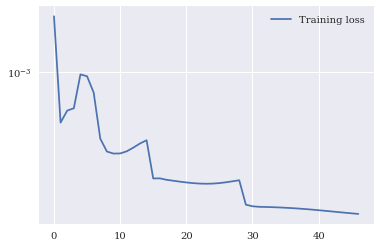

In [252]:
y_train_pred, y_train, y_test_pred, y_test, lstm = train(trial_lstm, "LSTM")

In [253]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('LSTM Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('LSTM Test Score: %.2f RMSE' % (testScore))

LSTM Train Score: 168.56 RMSE
LSTM Test Score: 164.08 RMSE


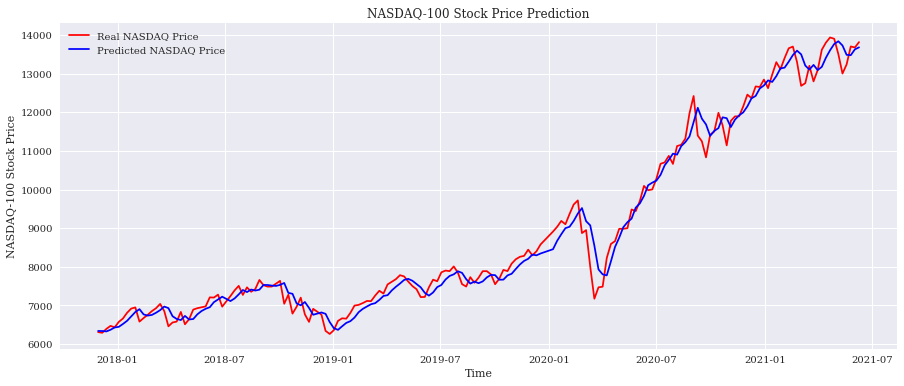

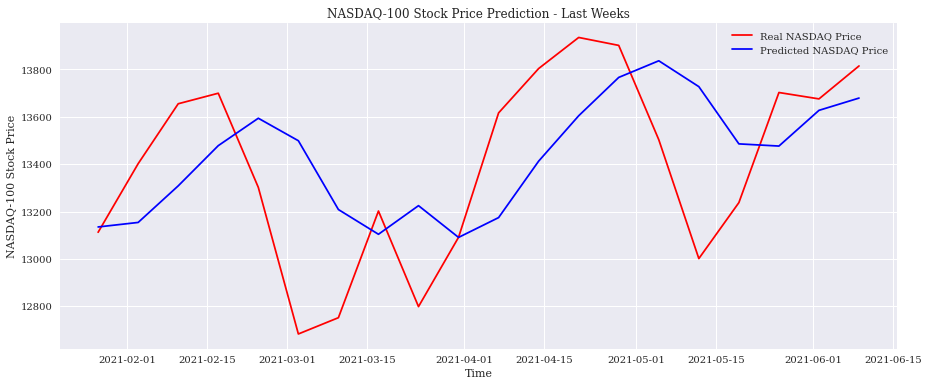

In [254]:
plot_results(lstm, batch_size = trial_lstm.params['Batch Size'])

[13779.130859375, 13811.82421875, 13852.7236328125, 13890.2236328125, 13926.478515625]


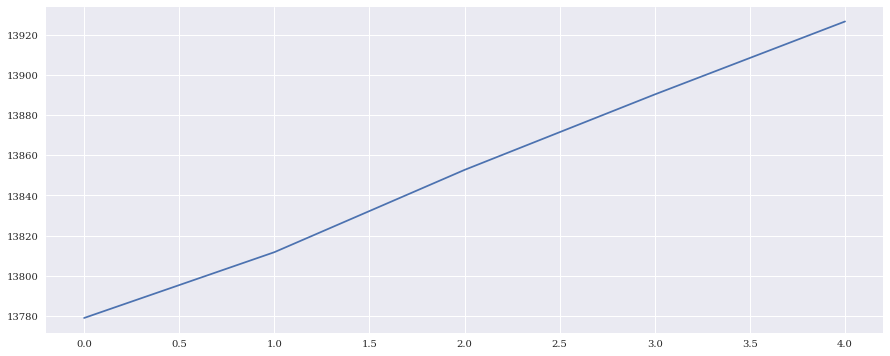

In [255]:
predict_results(lstm)

# Naive Predictor

In [256]:
dt = nasdaq.index[-1]-nasdaq.index[0]
dt = int(dt.days/7)
avg_weekly_gain = (nasdaq.iloc[-1,0]/nasdaq.iloc[0,0])**(1/dt)
#dt = len(nasdaq)
print('Nasdaw avegage weekly gain: %.2f' % (avg_weekly_gain))
dates = nasdaq.index
d0 = dates[0]
#naive = nasdaq.iloc[0,0]*avg_weekly_gain**((dates-d0).days/7)
naive = nasdaq['Close']*avg_weekly_gain
naiveScore = math.sqrt(mean_squared_error(naive[:-1], nasdaq['Close'][1:]))
print('Naive Predictor Score: %.2f RMSE' % (naiveScore))

1.0027133979117822
Naive Predictor Score: 131.50 RMSE


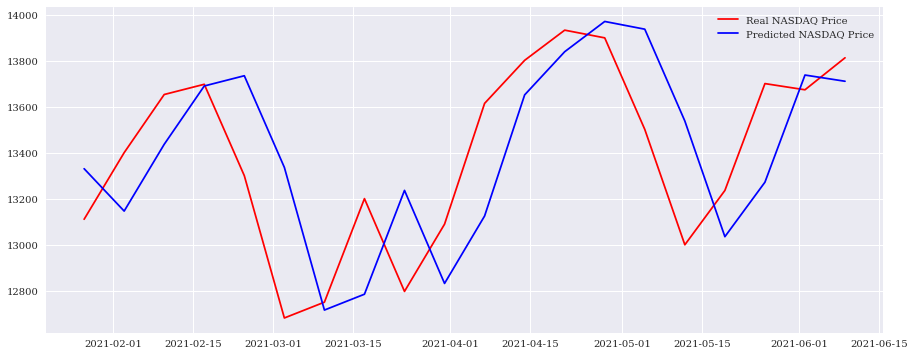

In [257]:
figure, axes = plt.subplots(figsize=(15, 6))
last = 20
axes.xaxis_date()
axes.plot(nasdaq[-last:].index, nasdaq['Close'][-last:], color = 'red', label = 'Real NASDAQ Price')
axes.plot(nasdaq[-last:].index, naive[-last-1:-1], color = 'blue', label = 'Predicted NASDAQ Price')
plt.legend()

# Prediction with GRU without Fed Data

In [258]:
nasdaq, scaled, scaler1, scaler2  = load_nasdaq(use_fed_data = False)
input_dim = 1

In [259]:
study_gru_no_fed = conduct_study ('GRU NO FED', 'GRU')

[I 2021-06-25 16:40:47,490] A new study created in memory with name: GRU NO FED
[I 2021-06-25 16:40:52,269] Trial 0 finished with value: 4.190116669633426e-05 and parameters: {'Look Back': 18, 'Batch Size': 18, 'Hidden Dim': 58, 'N layers': 1, 'Learning Rate': 0.021530970935073904, 'Num Iters': 2164, 'Factor': 0.3932192333113216, 'Patience': 18}. Best is trial 0 with value: 4.190116669633426e-05.
[I 2021-06-25 16:41:09,773] Trial 1 finished with value: 0.00010046281386166811 and parameters: {'Look Back': 24, 'Batch Size': 124, 'Hidden Dim': 27, 'N layers': 5, 'Learning Rate': 0.026503789828921768, 'Num Iters': 2509, 'Factor': 0.34038879142834233, 'Patience': 11}. Best is trial 0 with value: 4.190116669633426e-05.
[I 2021-06-25 16:41:23,031] Trial 2 finished with value: 7.133310282370076e-05 and parameters: {'Look Back': 21, 'Batch Size': 242, 'Hidden Dim': 32, 'N layers': 4, 'Learning Rate': 0.001015071527321519, 'Num Iters': 2385, 'Factor': 0.3375041538520037, 'Patience': 5}. Best is 

[I 2021-06-25 16:45:24,525] Trial 52 finished with value: 4.377412915346213e-05 and parameters: {'Look Back': 18, 'Batch Size': 28, 'Hidden Dim': 41, 'N layers': 2, 'Learning Rate': 0.027018538211929115, 'Num Iters': 2749, 'Factor': 0.2662460973646736, 'Patience': 18}. Best is trial 27 with value: 2.7214340661885217e-05.
[I 2021-06-25 16:45:25,309] Trial 53 pruned. 
[I 2021-06-25 16:45:25,441] Trial 54 pruned. 
[I 2021-06-25 16:45:25,650] Trial 55 pruned. 
[I 2021-06-25 16:45:26,947] Trial 56 pruned. 
[I 2021-06-25 16:45:27,079] Trial 57 pruned. 
[I 2021-06-25 16:45:28,086] Trial 58 pruned. 
[I 2021-06-25 16:45:28,314] Trial 59 pruned. 
[I 2021-06-25 16:45:28,505] Trial 60 pruned. 
[I 2021-06-25 16:45:37,677] Trial 61 finished with value: 4.0471513784723356e-05 and parameters: {'Look Back': 19, 'Batch Size': 29, 'Hidden Dim': 39, 'N layers': 2, 'Learning Rate': 0.017444944081882987, 'Num Iters': 2834, 'Factor': 0.31557896377986305, 'Patience': 20}. Best is trial 27 with value: 2.721434

[I 2021-06-25 16:48:29,490] Trial 134 pruned. 
[I 2021-06-25 16:48:29,669] Trial 135 pruned. 
[I 2021-06-25 16:48:30,026] Trial 136 pruned. 
[I 2021-06-25 16:48:30,199] Trial 137 pruned. 
[I 2021-06-25 16:48:30,578] Trial 138 pruned. 
[I 2021-06-25 16:48:30,785] Trial 139 pruned. 
[I 2021-06-25 16:48:42,492] Trial 140 pruned. 
[I 2021-06-25 16:48:42,892] Trial 141 pruned. 
[I 2021-06-25 16:48:58,552] Trial 142 finished with value: 2.741143362072762e-05 and parameters: {'Look Back': 57, 'Batch Size': 27, 'Hidden Dim': 41, 'N layers': 2, 'Learning Rate': 0.018163293389988084, 'Num Iters': 3382, 'Factor': 0.5845878548559227, 'Patience': 1}. Best is trial 125 with value: 1.7991018467000686e-05.
[I 2021-06-25 16:48:58,738] Trial 143 pruned. 
[I 2021-06-25 16:48:59,121] Trial 144 pruned. 
[I 2021-06-25 16:49:01,954] Trial 145 pruned. 
[I 2021-06-25 16:49:02,266] Trial 146 pruned. 
[I 2021-06-25 16:49:02,340] Trial 147 pruned. 
[I 2021-06-25 16:49:02,519] Trial 148 pruned. 
[I 2021-06-25 16:4

Study statistics: 
  Number of finished trials:  200
  Number of pruned trials:  164
  Number of complete trials:  36


In [260]:
optuna.visualization.plot_param_importances(study_gru_no_fed)

In [261]:
print("Best trial:")
trial_gru_no_fed = study_gru_no_fed.best_trial

print("Loss: ", trial_gru_no_fed.value)
print(trial_gru_no_fed.params)

Best trial:
Loss:  1.7991018467000686e-05
{'Look Back': 52, 'Batch Size': 25, 'Hidden Dim': 43, 'N layers': 2, 'Learning Rate': 0.018734770960791045, 'Num Iters': 3456, 'Factor': 0.5430342947285256, 'Patience': 4}


Epoch  0 MSE:  0.001301222713664174
Epoch  20 MSE:  2.1888408809900284e-05
Epoch  40 MSE:  1.5429452105308883e-05
Epoch  60 MSE:  1.772298310243059e-05
Epoch  80 MSE:  1.7962274796445854e-05
Epoch  100 MSE:  1.798754783521872e-05
Epoch  120 MSE:  1.799087658582721e-05
Last Epoch  122 MSE:  1.7991018467000686e-05


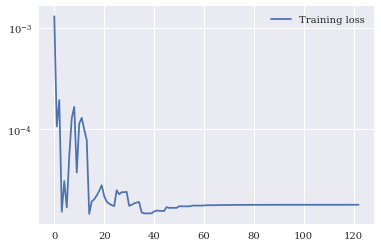

In [262]:
y_train_pred, y_train, y_test_pred, y_test, gru_no_fed = train(trial_gru_no_fed, "GRU")

In [263]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('GRU without fed Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('GRU without fed Test Score: %.2f RMSE' % (testScore))

GRU without fed Train Score: 127.25 RMSE
GRU without fed Test Score: 160.23 RMSE


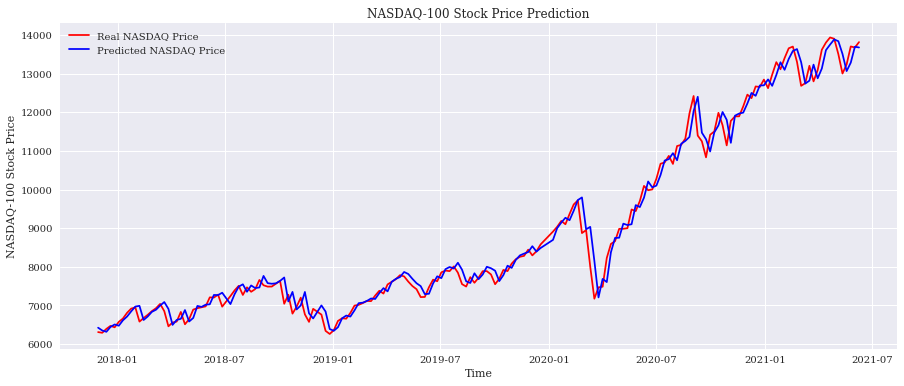

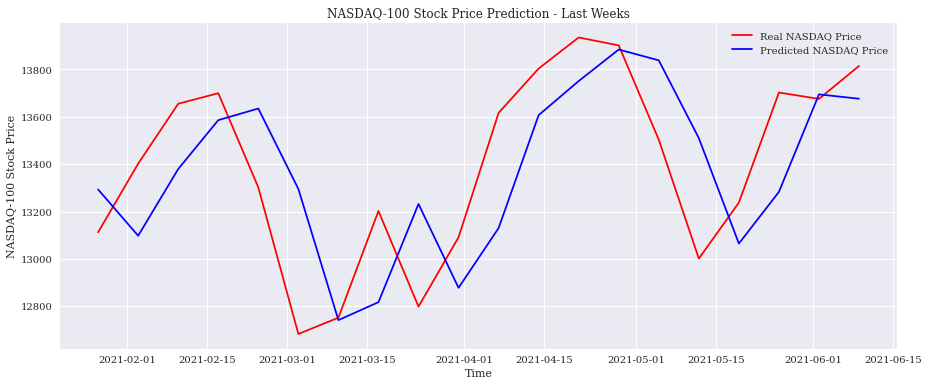

In [264]:
plot_results(gru_no_fed, batch_size = trial_gru_no_fed.params['Batch Size'])

[13792.12890625, 13776.4228515625, 13757.2724609375, 13754.75, 13742.91015625]


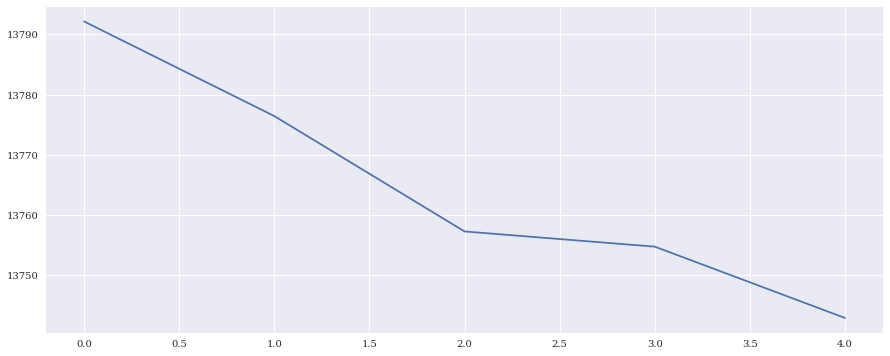

In [265]:
predict_results(gru_no_fed)

# Prediction with LSTM without Fed Data

In [266]:
study_lstm_no_fed = conduct_study('LSTM NO FED', 'LSTM')

[I 2021-06-25 16:50:20,580] A new study created in memory with name: LSTM NO FED
[I 2021-06-25 16:50:37,967] Trial 0 finished with value: 0.00012092482211301103 and parameters: {'Look Back': 27, 'Batch Size': 91, 'Hidden Dim': 82, 'N layers': 3, 'Learning Rate': 0.002041198214676447, 'Num Iters': 3253, 'Factor': 0.820391475651971, 'Patience': 28}. Best is trial 0 with value: 0.00012092482211301103.
[I 2021-06-25 16:50:55,892] Trial 1 finished with value: 0.0011348953703418374 and parameters: {'Look Back': 31, 'Batch Size': 85, 'Hidden Dim': 38, 'N layers': 5, 'Learning Rate': 0.0318082025296452, 'Num Iters': 2331, 'Factor': 0.2800942795745536, 'Patience': 3}. Best is trial 0 with value: 0.00012092482211301103.
[I 2021-06-25 16:51:03,622] Trial 2 finished with value: 0.00010823625780176371 and parameters: {'Look Back': 41, 'Batch Size': 34, 'Hidden Dim': 69, 'N layers': 4, 'Learning Rate': 0.0020999605886493793, 'Num Iters': 1065, 'Factor': 0.6041007679218032, 'Patience': 21}. Best is t

[I 2021-06-25 16:56:55,709] Trial 77 pruned. 
[I 2021-06-25 16:56:56,043] Trial 78 pruned. 
[I 2021-06-25 16:57:21,744] Trial 79 finished with value: 3.4769895137287676e-05 and parameters: {'Look Back': 96, 'Batch Size': 23, 'Hidden Dim': 29, 'N layers': 5, 'Learning Rate': 0.0225558688271402, 'Num Iters': 2116, 'Factor': 0.45863449087608754, 'Patience': 6}. Best is trial 79 with value: 3.4769895137287676e-05.
[I 2021-06-25 16:57:22,287] Trial 80 pruned. 
[I 2021-06-25 16:57:23,403] Trial 81 pruned. 
[I 2021-06-25 16:58:00,338] Trial 82 finished with value: 3.241289596189745e-05 and parameters: {'Look Back': 83, 'Batch Size': 31, 'Hidden Dim': 29, 'N layers': 5, 'Learning Rate': 0.024634112789725663, 'Num Iters': 3264, 'Factor': 0.4327689962341282, 'Patience': 9}. Best is trial 82 with value: 3.241289596189745e-05.
[I 2021-06-25 16:58:02,057] Trial 83 pruned. 
[I 2021-06-25 16:58:02,512] Trial 84 pruned. 
[I 2021-06-25 16:58:02,851] Trial 85 pruned. 
[I 2021-06-25 16:58:02,971] Trial 8

[I 2021-06-25 17:05:25,545] Trial 148 finished with value: 3.308383747935295e-05 and parameters: {'Look Back': 77, 'Batch Size': 31, 'Hidden Dim': 42, 'N layers': 2, 'Learning Rate': 0.013304921147008401, 'Num Iters': 3737, 'Factor': 0.15510516095055232, 'Patience': 30}. Best is trial 147 with value: 1.6957072148215957e-05.
[I 2021-06-25 17:05:55,727] Trial 149 finished with value: 3.590101914596744e-05 and parameters: {'Look Back': 77, 'Batch Size': 31, 'Hidden Dim': 42, 'N layers': 2, 'Learning Rate': 0.01259452621737181, 'Num Iters': 3732, 'Factor': 0.15441319480731613, 'Patience': 30}. Best is trial 147 with value: 1.6957072148215957e-05.
[I 2021-06-25 17:05:56,134] Trial 150 pruned. 
[I 2021-06-25 17:05:57,149] Trial 151 pruned. 
[I 2021-06-25 17:06:26,692] Trial 152 finished with value: 2.7577665605349466e-05 and parameters: {'Look Back': 75, 'Batch Size': 31, 'Hidden Dim': 42, 'N layers': 2, 'Learning Rate': 0.016136520670176954, 'Num Iters': 3710, 'Factor': 0.14869855894415346,

Study statistics: 
  Number of finished trials:  200
  Number of pruned trials:  160
  Number of complete trials:  40


In [267]:
optuna.visualization.plot_param_importances(study_lstm_no_fed)

In [268]:
print("Best trial:")
trial_lstm_no_fed = study_lstm_no_fed.best_trial

print("Loss: ", trial_lstm_no_fed.value)
print(trial_lstm_no_fed.params)

Best trial:
Loss:  1.6957072148215957e-05
{'Look Back': 79, 'Batch Size': 30, 'Hidden Dim': 48, 'N layers': 2, 'Learning Rate': 0.011304411063927971, 'Num Iters': 3697, 'Factor': 0.14101688576876048, 'Patience': 30}


Epoch  0 MSE:  0.016888337209820747
Epoch  20 MSE:  9.422753646504134e-05
Epoch  40 MSE:  8.530865306966007e-05
Epoch  60 MSE:  3.5160341212758794e-05
Epoch  80 MSE:  4.1686966142151505e-05
Epoch  100 MSE:  2.303923793078866e-05
Epoch  120 MSE:  3.1310642953030765e-05
Epoch  140 MSE:  2.2041120246285573e-05
Last Epoch  159 MSE:  2.0332501662778668e-05


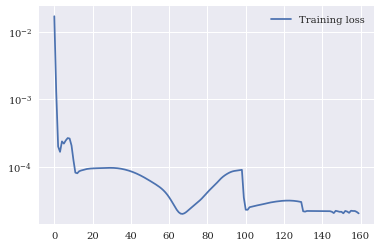

In [269]:
y_train_pred, y_train, y_test_pred, y_test, lstm_no_fed = train(trial_lstm_no_fed, "LSTM")

In [270]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('LSTM without fed Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('LSTM without fed Test Score: %.2f RMSE' % (testScore))

LSTM without fed Train Score: 130.02 RMSE
LSTM without fed Test Score: 144.73 RMSE


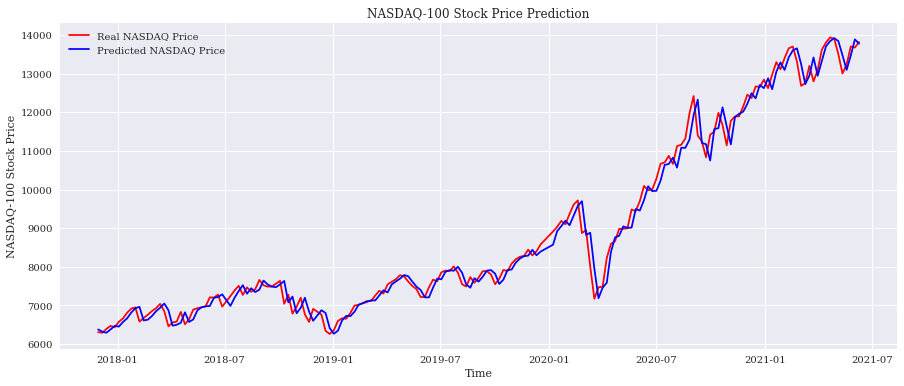

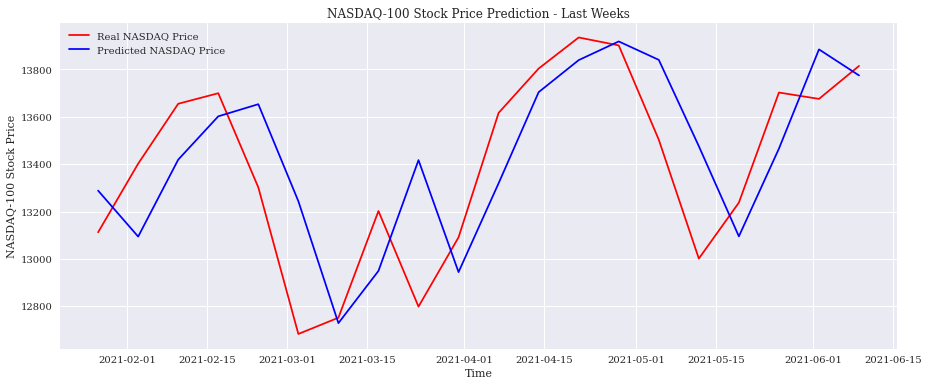

In [271]:
plot_results(lstm_no_fed, batch_size = trial_lstm_no_fed.params['Batch Size'])

[13893.3310546875, 13893.8603515625, 13919.5, 13955.123046875, 14000.37109375]


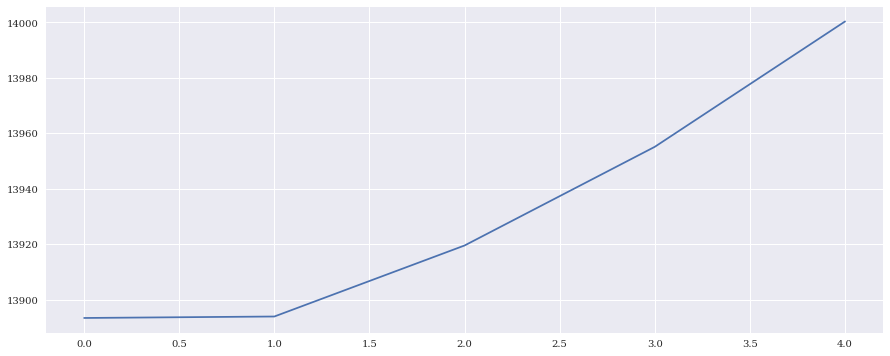

In [272]:
predict_results(lstm_no_fed)